<a href="https://colab.research.google.com/github/twishi03/scRNA/blob/main/Palantir_Cell_Differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb

In [1]:
!pip install scvelo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.2 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52019 sha256=507cf9facbdaafaf44e28efcaf4fccf8204bd9b6e0a697e01c640657969c5ff3
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
  Created wheel for umap-learn: filename=umap_learn-0.5

In [3]:
!pip install palantir

In [4]:
! pip install scanpy

In [5]:
import scvelo as scv
import palantir
import scanpy as sc
import pandas as pd
import os

In [20]:
# Plotting
import matplotlib
import matplotlib.pyplot as plt

In [6]:
# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

In [7]:
# Load sample data
data_dir = os.path.expanduser("./")
download_url = "https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad"
file_path = os.path.join(data_dir, "marrow_sample_scseq_counts.h5ad")
ad = sc.read(file_path, backup_url=download_url)
ad

  0%|          | 0.00/69.9M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 4142 × 16106

In [9]:
 sc.pp.normalize_per_cell(ad)

In [10]:
palantir.preprocess.log_transform(ad)

In [11]:
sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor="cell_ranger")

In [12]:
sc.pp.pca(ad)

In [13]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [14]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(ad, n_components=5)

In [15]:
ms_data = palantir.utils.determine_multiscale_space(ad)

In [16]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

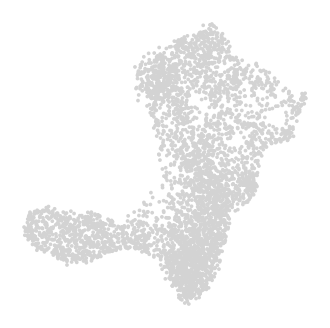

In [17]:
# Use scanpy functions to visualize umaps or FDL
sc.pl.embedding(
    ad,
    basis="umap",
    frameon=False,
)

In [18]:
imputed_X = palantir.utils.run_magic_imputation(ad)

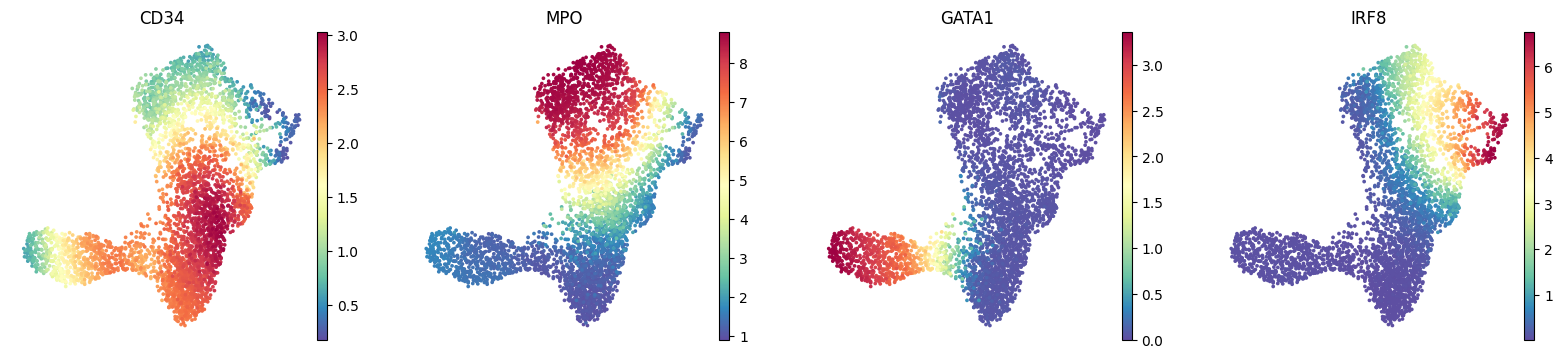

In [21]:
sc.pl.embedding(
    ad,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CD34", "MPO", "GATA1", "IRF8"],
    frameon=False,
)
plt.show()

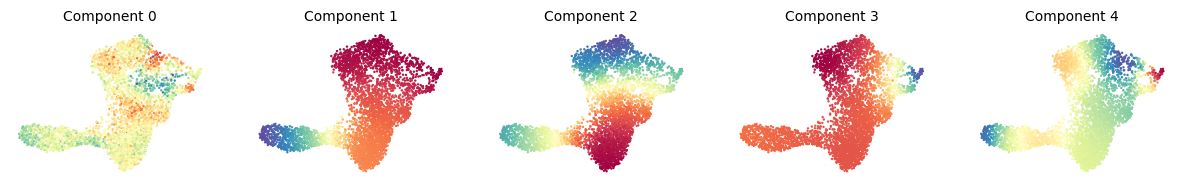

In [22]:
palantir.plot.plot_diffusion_components(ad)
plt.show()

In [23]:
terminal_states = pd.Series(
    ["DC", "Mono", "Ery"],
    index=["Run5_131097901611291", "Run5_134936662236454", "Run4_200562869397916"],
)

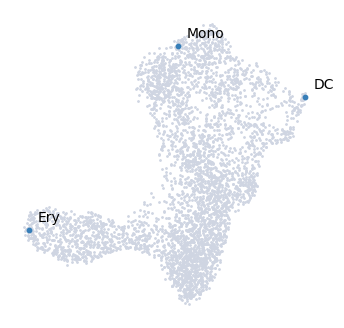

In [24]:
palantir.plot.highlight_cells_on_umap(ad, terminal_states)
plt.show()

In [25]:
start_cell = "Run5_164698952452459"
pr_res = palantir.core.run_palantir(
    ad, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.006551730632781983 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.276358433564504 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


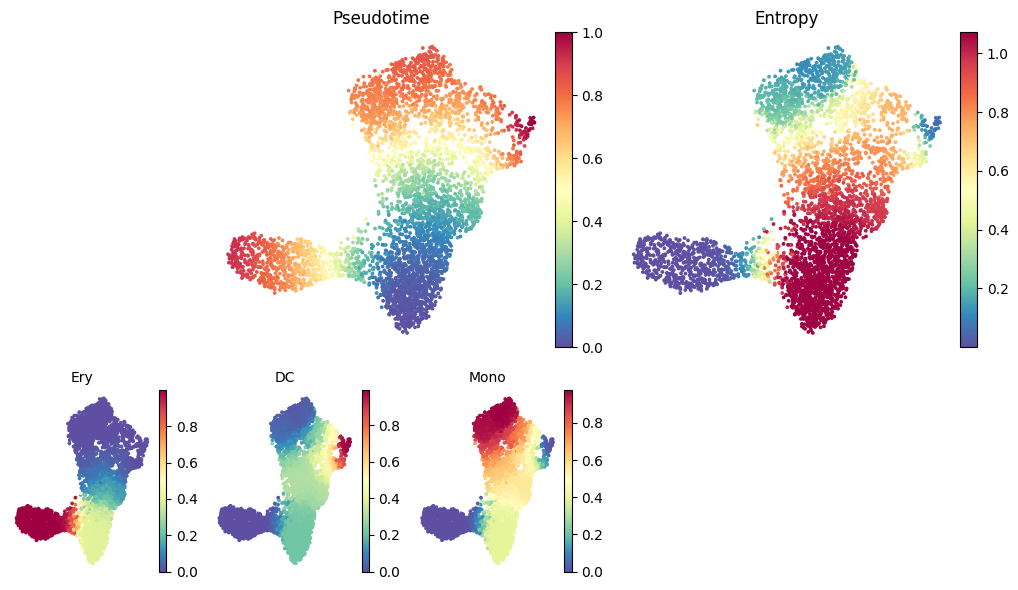

In [26]:
palantir.plot.plot_palantir_results(ad, s=3)
plt.show()

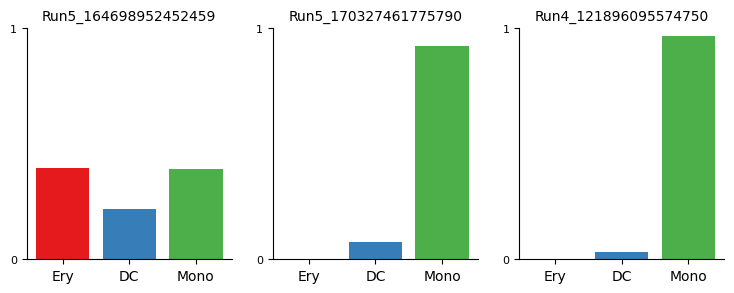

In [27]:
cells = [
    "Run5_164698952452459",
    "Run5_170327461775790",
    "Run4_121896095574750",
]
palantir.plot.plot_terminal_state_probs(ad, cells)
plt.show()

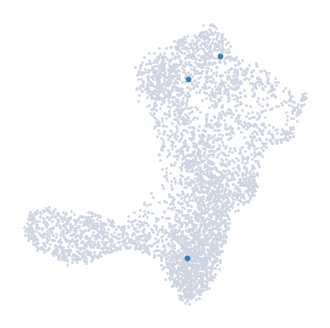

In [28]:
palantir.plot.highlight_cells_on_umap(ad, cells)
plt.show()

In [29]:
masks = palantir.presults.select_branch_cells(ad, eps=0)

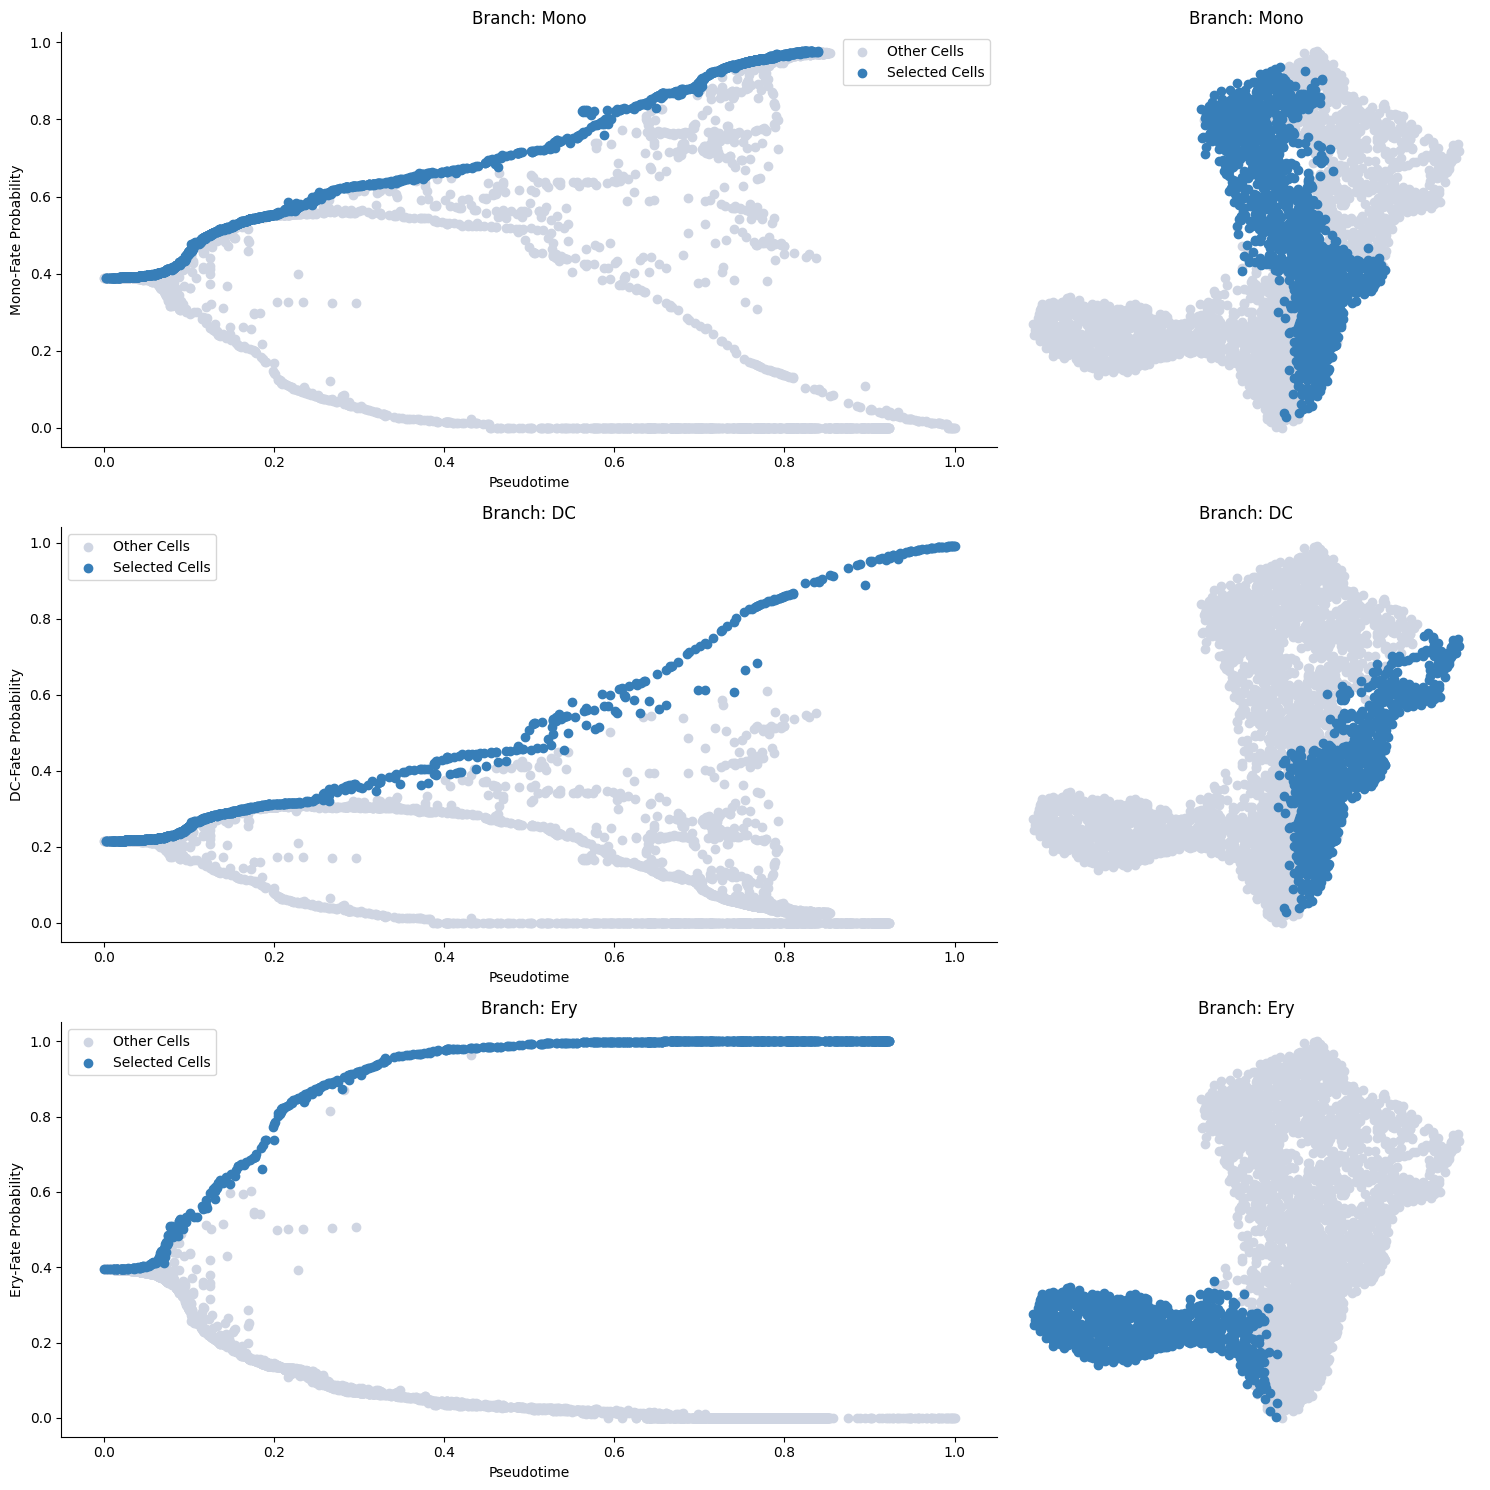

In [30]:
palantir.plot.plot_branch_selection(ad)
plt.show()

[2024-04-01 08:07:31,262] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (882) and rank = 1.0.
[2024-04-01 08:07:31,265] [INFO    ] Using covariance function Matern52(ls=1.0799293518066406).
[2024-04-01 08:07:31,335] [INFO    ] Computing 50 landmarks with k-means clustering.


<Axes: title={'center': 'Branch: Ery'}>

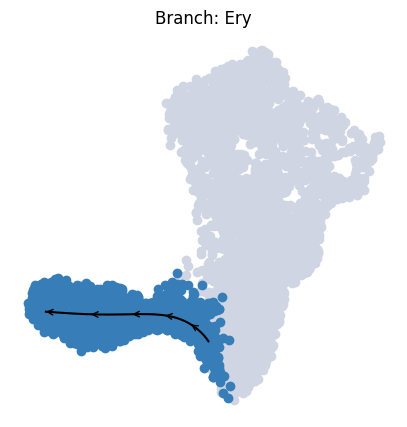

In [31]:
palantir.plot.plot_trajectory(ad, "Ery")

[2024-04-01 08:07:58,495] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (948) and rank = 1.0.
[2024-04-01 08:07:58,502] [INFO    ] Using covariance function Matern52(ls=1.0799293518066406).
[2024-04-01 08:07:58,575] [INFO    ] Computing 50 landmarks with k-means clustering.


<Axes: title={'center': 'Branch: DC'}, xlabel='UMAP1', ylabel='UMAP2'>

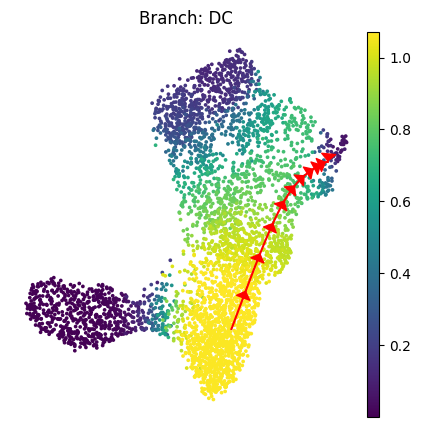

In [32]:
palantir.plot.plot_trajectory(
    ad,
    "DC",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),
)

In [33]:
gene_trends = palantir.presults.compute_gene_trends(
    ad,
    expression_key="MAGIC_imputed_data",
)

Ery
[2024-04-01 08:08:18,501] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (882) and rank = 1.0.
[2024-04-01 08:08:18,507] [INFO    ] Using covariance function Matern52(ls=1.0).
DC
[2024-04-01 08:08:25,640] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (948) and rank = 1.0.
[2024-04-01 08:08:25,642] [INFO    ] Using covariance function Matern52(ls=1.0).
Mono
[2024-04-01 08:08:30,718] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,667) and rank = 1.0.
[2024-04-01 08:08:30,720] [INFO    ] Using covariance function Matern52(ls=1.0).


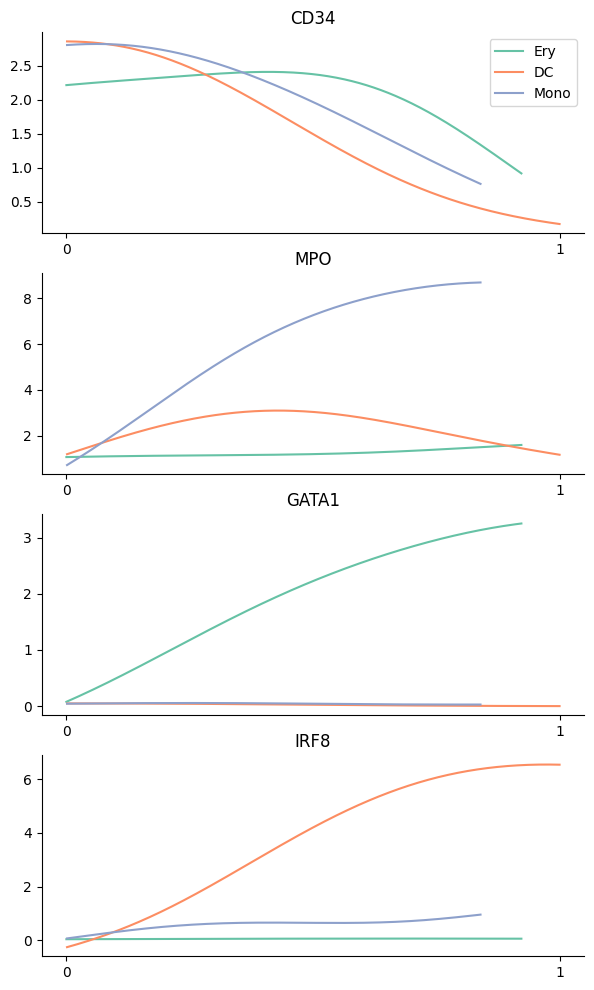

In [34]:
genes = ["CD34", "MPO", "GATA1", "IRF8"]
palantir.plot.plot_gene_trends(ad, genes)
plt.show()

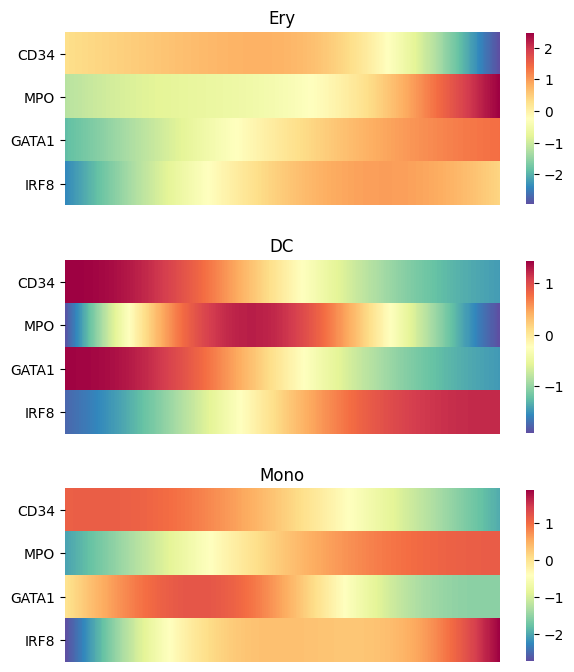

In [35]:
palantir.plot.plot_gene_trend_heatmaps(ad, genes)
plt.show()

In [36]:

more_genes = ad.var_names[:1000]
communities = palantir.presults.cluster_gene_trends(ad, "Ery", more_genes)

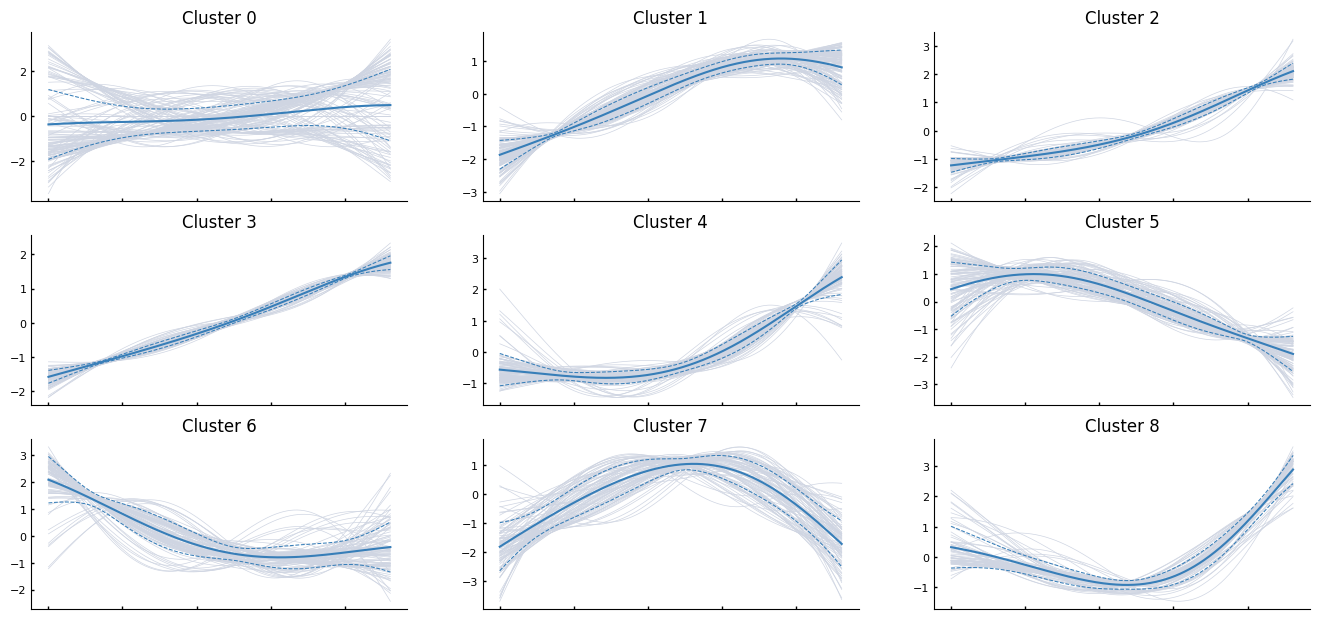

In [37]:
palantir.plot.plot_gene_trend_clusters(ad, "Ery")
plt.show()

In [38]:
file_path = os.path.join(data_dir, "marrow_sample_scseq_processed.h5ad")
ad.write(file_path)